# Checagem de vantagens transitórias para Nereu

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns   

from utils_ccd import get_connection, get_info_file_path, extract_text_from_pdf

from langchain_openai import  AzureChatOpenAI
from langchain.prompts import PromptTemplate

conn = get_connection()

# Todos os débitos

In [90]:
sql_debitos_nereu_query = """
SELECT DISTINCT 
        ed.IdDebito as id_debito,
        gp.Documento,
        gp.Nome,
       CONCAT(pro_exe.numero_processo, '/', pro_exe.ano_processo) as processo_execucao,
       pro_orig.codigo_tipo_processo,
       pro_exe.assunto,
       etd.Descricao as tipo_multa,
       edmc.DataFinalImputacaoMultaCominatoria as data_final_cominatoria,
       CONCAT(gp.Nome, ' (CPF: ', gp.Documento, ')') as nome,
       processo.dbo.fn_Exe_RetornaValorAtualizado(ed.IdDebito) as valor_multa,
       r.nome as relator,
       ed.IdProcessoOrigem as id_processo_origem,
       (
        SELECT CONCAT(numero_processo, '/', ano_processo)
        FROM processo.dbo.Processos
        WHERE IdProcesso = ed.IdProcessoOrigem
       ) as processo_origem,
       pro_orig.codigo_tipo_processo as tipo_processo_origem,
       (
        SELECT o.nome
		FROM processo.dbo.Orgaos o
		WHERE o.IdOrgao = pro_orig.IdOrgaoEnvolvido
       ) as orgao_envolvido_processo_origem,
       ed.IdProcessoExecucao as id_processo_execucao,
       esd.DescricaoStatusDivida as status_divida
	FROM processo.dbo.Exe_Debito ed 
	LEFT JOIN processo.dbo.Processos pro_orig ON ed.IdProcessoOrigem = pro_orig.IdProcesso
	LEFT JOIN processo.dbo.Processos pro_exe ON ed.IdProcessoExecucao = pro_exe.IdProcesso
	LEFT JOIN processo.dbo.Relator r ON r.codigo = pro_exe.codigo_relator 
	LEFT JOIN processo.dbo.Exe_DebitoPessoa edp ON edp.IDDebito = ed.IdDebito
	LEFT JOIN processo.dbo.Exe_TipoDebito etd ON etd.CodigoTipoDebito = ed.CodigoTipoDebito
	LEFT JOIN processo.dbo.GenPessoa gp ON gp.IdPessoa = edp.IDPessoa
	LEFT JOIN processo.dbo.Exe_StatusDivida esd ON esd.CodigoStatusDivida = ed.CodigoStatusDivida
	LEFT JOIN processo.dbo.Exe_Debito_MultaCominatoria edmc ON ed.IdDebito = edmc.IdDebito
	WHERE gp.Documento = '13006444434'

"""
df_debitos_nereu = pd.read_sql(sql_debitos_nereu_query, conn)

/tmp/ipykernel_11241/2508274557.py:40: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_debitos_nereu = pd.read_sql(sql_debitos_nereu_query, conn)


In [91]:
df_debitos_nereu.columns

Index(['id_debito', 'Documento', 'Nome', 'processo_execucao',
       'codigo_tipo_processo', 'assunto', 'tipo_multa',
       'data_final_cominatoria', 'nome', 'valor_multa', 'relator',
       'id_processo_origem', 'processo_origem', 'tipo_processo_origem',
       'orgao_envolvido_processo_origem', 'id_processo_execucao',
       'status_divida'],
      dtype='object')

In [92]:
len(df_debitos_nereu)

649

In [93]:
processos_origem = df_debitos_nereu['processo_origem'].unique()

In [94]:
processos_busca = ', '.join(f"'{proc}'" for proc in processos_origem)

sql_all_informacoes_processos = f'''
SELECT concat(rtrim(inf.setor),'_',inf.numero_processo ,'_',inf.ano_processo,'_',RIGHT(concat('0000',inf.ordem),4),'.pdf') as arquivo,
ppe.SequencialProcessoEvento as evento,
CONCAT(inf.numero_processo,'/', inf.ano_processo) as processo,
inf.*
FROM processo.dbo.vw_ata_informacao inf INNER JOIN processo.dbo.Pro_ProcessoEvento ppe 
    ON inf.idinformacao = ppe.idinformacao
WHERE concat(inf.numero_processo, '/', inf.ano_processo) in ({processos_busca})
'''
all_informacoes_processos = pd.read_sql(sql_all_informacoes_processos, conn)
all_informacoes_processos['caminho_arquivo'] = all_informacoes_processos.apply(get_info_file_path, axis=1)

/tmp/ipykernel_11241/2327087101.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  all_informacoes_processos = pd.read_sql(sql_all_informacoes_processos, conn)


In [95]:
all_informacoes_processos['resumo'].fillna('', inplace=True)

In [96]:
decisoes = f'''
SELECT *
FROM processo.dbo.vw_ia_votos_acordaos_decisoes
WHERE concat(numeroprocesso, '/', anoprocesso) in ({processos_busca})
'''
df_decisoes = pd.read_sql(decisoes, conn)

/tmp/ipykernel_11241/2911930637.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_decisoes = pd.read_sql(decisoes, conn)


In [97]:
df_decisoes.columns

Index(['idvoto', 'codigo_tipo_processo', 'descricao', 'TipoVoto',
       'VotoEscolhido', 'idInformacao_voto', 'INFO_arquivo_Voto',
       'IdComposicaoPauta', 'CodigoCamara', 'numero_sessao', 'ano_sessao',
       'DataSessao', 'numeroResultado', 'anoResultado', 'resultadoTipo',
       'IdApreciacao', 'idTipoRecurso', 'IdTipoVotacao', 'decisao',
       'idVotoPauta', 'idVotoDecisao', 'NomeRelator', 'Setor', 'ementa',
       'assunto', 'NumeroProcesso', 'AnoProcesso', 'NomeRelatorProcesso',
       'IdProcesso', 'OrgaoOrigem', 'interessado', 'Divergente_de_idVoto',
       'isVotoDivergente', 'IdVotoConcordado', 'Relatorio',
       'FundamentacaoVoto', 'Conclusao', 'texto_acordao', 'SetorVoto',
       'DescricaoTipoVoto'],
      dtype='object')

In [98]:
df_decisoes['processo'] = df_decisoes.apply(
    lambda x: f"{x['NumeroProcesso']}/{x['AnoProcesso']}", axis=1
)

In [99]:
df_decisoes[['processo', 'texto_acordao']]

,processo,texto_acordao
0,004784/2013,DECIDEM os Conselheiros do Tribunal de Contas ...
1,017428/2012,DECIDEM os Conselheiros do Tribunal de Contas ...
2,004605/2005,DECIDEM os Conselheiros do Tribunal de Contas ...
3,002261/2008,"Vistos, relatados e discutidos estes autos, no..."
4,011038/2014,DECIDEM os Conselheiros do Tribunal de Contas ...
...,...,...
865,018874/2016,"Vistos, relatados e discutidos estes autos, AC..."
866,018813/2016,"Vistos, relatados e discutidos estes autos, AC..."
867,018607/2016,"Vistos, relatados e discutidos estes autos, AC..."
868,017491/2017,"Vistos, relatados e discutidos estes autos, AC..."


In [100]:
decisoes_grp = df_decisoes.groupby('processo').agg({
    'texto_acordao': lambda x: '\n'.join(x.dropna().astype(str)),
    'ementa': lambda x: '\n'.join(x.dropna().astype(str))
}).reset_index()

In [101]:
decisoes_grp.head()

,processo,texto_acordao,ementa
0,000002/2016,DECIDEM os Conselheiros do Tribunal de Contas ...,EMENTA: CONSTITUCIONAL. ADMINISTRATIVO. PREVID...
1,000197/2004,"Vistos, relatados e discutidos estes autos do ...",EMENTA: CONSTITUCIONAL. ADMINISTRATIVO. APOSEN...
2,000259/2017,DECIDEM os Conselheiros do Tribunal de Contas ...,EMENTA: CONSTITUCIONAL. ADMINISTRATIVO. APOSEN...
3,000266/2017,DECIDEM os Conselheiros do Tribunal de Contas ...,EMENTA: CONSTITUCIONAL. ADMINISTRATIVO. PREVID...
4,000301/2017,DECIDEM os Conselheiros do Tribunal de Contas ...,"CONSTITUCIONAL, ADMINISTRATIVO E PREVIDENCIÁRI..."


In [102]:
def is_natureza_transitoria(ementa):
    if pd.isna(ementa):
        return False
    keywords = ['propter lab', 'natureza transit', 'vantagens transit', 'vantagem transit']
    return any(keyword in ementa.lower() for keyword in keywords)

In [103]:
decisoes_grp['verbas_transitorias'] = decisoes_grp['ementa'].apply(lambda x: 'SIM' if is_natureza_transitoria(x) else 'NÃO')

<Axes: >

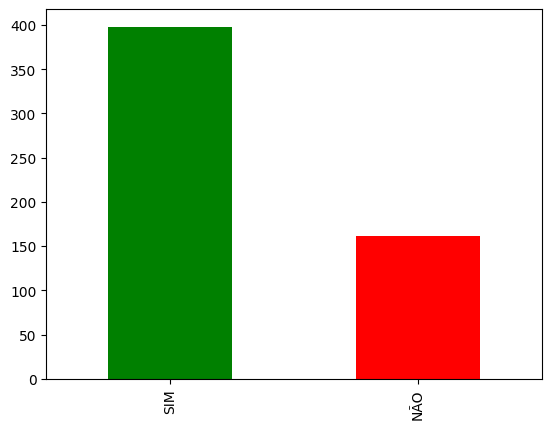

In [104]:
decisoes_grp['verbas_transitorias'].value_counts().plot(kind='bar', color=['green', 'red'])

In [105]:
llm = AzureChatOpenAI(model_name="gpt-4o")

def get_categoria_ementa(texto):
    try:
        prompt = PromptTemplate.from_template("""
        Você é um agente que analisa e categoriza ementas de decisões do TCE/RN.
        Todas as ementas são sobre processos de débito, multas e outras questões relacionadas a contas públicas.
        Seu objetivo é resumir o motivo da imputação de multa
        O texto das ementas é o seguinte:
        "{input}"
                                              
        Defina a categora resumida do objeto/assunto principal. 
        Se a ementa falar algo como 'DIANTE DA NATUREZA PROPTER LABOREM DO ADICIONAL DE INSALUBRIDADE'
        Use a categoria 'Verba Transitória'.                                     

        Se a ementa falar algo como ' AUSÊNCIA DE REMESSA DO PROCESSO DE PENSÃO A ESTA CORTE DE CONTAS OU DE APRESENTAÇÃO DE JUSTIFICATIVA DE SUA INEXISTÊNCIA.' 
        Use a categoria 'Ausência de remessa de processo ao TCE'.

        Caso contrário, crie uma categoria que resuma o assunto principal da ementa. Use um texto curto, de no máximo 8 palavras.                                      
        
        Sua resposta:
        """)

        chain = prompt | llm
        msg_obj = chain.invoke(texto)
        return msg_obj.content
    except Exception as e:
        print(f"Error processing {texto}: {e}")
        return None
    


In [106]:
#decisoes_grp['categoria_ementa'] = decisoes_grp['ementa'].apply(get_categoria_ementa)

In [107]:
#decisoes_grp.drop(columns=['categoria_ementa'], inplace=True)

In [108]:
sql_processos_origem = f'''
SELECT CONCAT(p.numero_processo, '/', p.ano_processo) as processo, gp.Documento as cpf, gp.Nome COLLATE SQL_Latin1_General_CP1_CI_AS as nome
FROM processo.dbo.Processos p INNER JOIN processo.dbo.Pro_ProcessosResponsavelDespesa pprd  ON p.IdProcesso = pprd.IdProcesso
INNER JOIN processo.dbo.GenPessoa gp ON gp.IdPessoa = pprd.IdPessoa 
WHERE CONCAT(p.numero_processo, '/', p.ano_processo) IN ({','.join([f"'{proc}'" for proc in processos_origem])})
AND gp.Documento NOT IN ('08242034000102', '13006444434') AND len(gp.Documento) = 11
'''
df_processos_origem = pd.read_sql(sql_processos_origem, conn)

/tmp/ipykernel_11241/595497275.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_processos_origem = pd.read_sql(sql_processos_origem, conn)


In [109]:
sql_pessoas_origem = f'''SELECT DISTINCT codigo_orgao, cpf
FROM BdDIP.dbo.vwSiaiPessoalFolhaResumida fr
WHERE fr.CPF IN ({','.join([f"'{cpf}'" for cpf in df_processos_origem['cpf'].unique()])}
)
AND fr.codigo_orgao NOT IN ('IPERN')
'''
df_pessoas_origem = pd.read_sql(sql_pessoas_origem, conn)


/tmp/ipykernel_11241/532772401.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_pessoas_origem = pd.read_sql(sql_pessoas_origem, conn)


In [110]:
df_pessoas_origem = df_pessoas_origem.groupby('cpf').agg({
    'codigo_orgao': pd.Series.tolist
}).reset_index()

processos_orgaos = df_processos_origem.merge(
    df_pessoas_origem,
    how='left',
    left_on='cpf',
    right_on='cpf',
    suffixes=('', '_pessoas')
)[['processo', 'cpf', 'nome', 'codigo_orgao']]
processos_orgaos


processos_orgaos.dropna(subset=['codigo_orgao'], inplace=True)

In [111]:
processos_orgaos.rename(columns={'codigo_orgao': 'orgaos_servidores_envolvidos', 'nome': 'servidores_envolvidos'}, inplace=True)

In [112]:
df_debitos_nereu.columns

Index(['id_debito', 'Documento', 'Nome', 'processo_execucao',
       'codigo_tipo_processo', 'assunto', 'tipo_multa',
       'data_final_cominatoria', 'nome', 'valor_multa', 'relator',
       'id_processo_origem', 'processo_origem', 'tipo_processo_origem',
       'orgao_envolvido_processo_origem', 'id_processo_execucao',
       'status_divida'],
      dtype='object')

In [124]:
tab_debitos = df_debitos_nereu[['id_debito', 'processo_origem', 'processo_execucao', 'orgao_envolvido_processo_origem', 'tipo_processo_origem', 'tipo_multa', 'valor_multa', 'relator', 'status_divida']]

In [125]:
tab_debitos = tab_debitos.merge(
    processos_orgaos,
    how='left',
    left_on='processo_origem',
    right_on='processo',
    suffixes=('', '_orgaos')
)[['id_debito', 'processo', 'processo_origem', 'processo_execucao', 'orgao_envolvido_processo_origem', \
   'tipo_processo_origem', 'tipo_multa', 'valor_multa', 'relator', 'status_divida',\
      'servidores_envolvidos', 'orgaos_servidores_envolvidos']]

In [126]:
tab_debitos = tab_debitos.merge(
    decisoes_grp,
    how='left',
    left_on='processo_origem',
    right_on='processo',
    suffixes=('', '_decisoes')
)

In [127]:
tab_debitos.columns

Index(['id_debito', 'processo', 'processo_origem', 'processo_execucao',
       'orgao_envolvido_processo_origem', 'tipo_processo_origem', 'tipo_multa',
       'valor_multa', 'relator', 'status_divida', 'servidores_envolvidos',
       'orgaos_servidores_envolvidos', 'processo_decisoes', 'texto_acordao',
       'ementa', 'verbas_transitorias'],
      dtype='object')

In [128]:
tab_debitos.drop(columns=['processo_decisoes'], inplace=True)
tab_debitos.rename(columns={
    'texto_acordao': 'texto_acordaos',
    'ementa': 'ementas_decisoes'
}, inplace=True)

In [129]:
tab_debitos['servidores_envolvidos'].fillna('Sem servidores envolvidos', inplace=True)
tab_debitos['orgaos_servidores_envolvidos'].fillna('Sem órgãos envolvidos', inplace=True)
tab_debitos['texto_acordaos'].fillna('Sem decisões', inplace=True)
tab_debitos['ementas_decisoes'].fillna('Sem decisões', inplace=True)
tab_debitos['verbas_transitorias'].fillna('', inplace=True)

In [ ]:
import locale

locale.setlocale(locale.LC_ALL, 'pt_BR.UTF-8')

tab_debitos['valor_multa'] = tab_debitos['valor_multa'].apply(lambda x: locale.currency(x, grouping=True, symbol=False) if pd.notnull(x) else '0,00')

In [120]:
tab_debitos.drop(columns=['processo'], inplace=True)

In [121]:
tab_debitos['processo_execucao'].unique()

array(['001081/2015', '/', '012970/2017', '002016/2024', '000137/2022',
       '000135/2022', '000134/2022', '000097/2022', '000151/2022',
       '000099/2022', '000131/2022', '000119/2022', '000143/2022',
       '000136/2022', '000142/2022', '000148/2022', '000147/2022',
       '002683/2022', '000133/2022', '000104/2022', '000120/2022',
       '000149/2022', '000103/2022', '000102/2022', '000096/2022',
       '000146/2022', '000141/2022', '000126/2022', '000150/2022',
       '001385/2022', '000139/2022', '000124/2022', '001386/2022',
       '000098/2022', '000106/2022', '000105/2022', '000122/2022',
       '000121/2022', '000156/2022', '001411/2022', '000110/2022',
       '000109/2022', '000145/2022', '000128/2022', '000127/2022',
       '000107/2022', '000123/2022', '000140/2022', '000114/2022',
       '000113/2022', '003011/2022', '000108/2022', '000101/2022',
       '000100/2022', '000130/2022', '000112/2022', '000116/2022',
       '003010/2022', '000152/2022', '000115/2022', '0001

In [134]:
tab_debitos['orgaos_servidores_envolvidos'] = tab_debitos['orgaos_servidores_envolvidos'].apply(
    lambda x: ', '.join(x) if isinstance(x, list) else x
)

In [139]:
tab_debitos

,id_debito,processo_origem,processo_execucao,orgao_envolvido_processo_origem,tipo_processo_origem,tipo_multa,valor_multa,relator,status_divida,servidores_envolvidos,orgaos_servidores_envolvidos,texto_acordaos,ementas_decisoes,verbas_transitorias
0,2760,007433/2005,001081/2015,INSTITUTO DE PREVIDÊNCIA DOS SERVIDORES DO RN,PEN,Multa,"136,58",RENATO COSTA DIAS,Cancelada por prescrição,Sem servidores envolvidos,Sem órgãos envolvidos,Sem decisões,Sem decisões,
1,10979,002113/2009,Sem processo de execução,INSTITUTO DE PREVIDÊNCIA DOS SERVIDORES DO RN,PEN,Multa,"118,11",None,Em Aberto,Sem servidores envolvidos,Sem órgãos envolvidos,Sem decisões,Sem decisões,
2,19752,012078/2012,012970/2017,None,PAG,Multa,"9.858,52",CARLOS THOMPSON COSTA FERNANDES,Cancelada por Erro de Cadastro,Maria das Graças Fernandes Costa da Motta,"FUNDAC, SEARH","Vistos, relatados e discutidos estes autos, em...",EMENTA: CONSTITUCIONAL. ADMINISTRATIVO E FINAN...,NÃO
3,19809,100897/2019,Sem processo de execução,INSTITUTO DE PREVIDÊNCIA DOS SERVIDORES DO RN,APO,Multa,"11.668,00",None,Cancelada por Erro de Cadastro,MARIA LUCIA SALVIANO DE OLIVEIRA,"SEARH, SESAP",DECIDEM os Conselheiros do Tribunal de Contas ...,EMENTA. CONSTITUCIONAL. ADMINISTRATIVO PREVIDE...,NÃO
4,19810,101097/2019,Sem processo de execução,INSTITUTO DE PREVIDÊNCIA DOS SERVIDORES DO RN,APO,Multa,"11.750,84",None,Cancelada por Erro de Cadastro,MARCOS ANTONIO BEZERRA CAVALCANTI,"SEARH, SESAP",DECIDEM os Conselheiros do Tribunal de Contas ...,EMENTA. CONSTITUCIONAL. ADMINISTRATIVO PREVIDÊ...,NÃO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
676,28252,018875/2016,Sem processo de execução,SECRETARIA DE ESTADO DA SAÚDE PUBLICA,APO,Multa,"1.003,60",None,Em Aberto,MARIA DO ROZARIO DE SOUZA,"PMTIBAU, SEARH, SESAP",DECIDEM os Conselheiros do Tribunal de Contas ...,EMENTA: APOSENTADORIA. INADEQUAÇÃO DO ATO ADMI...,SIM
677,28253,022595/2016,Sem processo de execução,SECRETARIA DE ESTADO DA SAÚDE PUBLICA,APO,Multa,"1.003,60",None,Em Aberto,SONIA MARIA VIEIRA,"SEARH, SESAP",DECIDEM os Conselheiros do Tribunal de Contas ...,EMENTA: APOSENTADORIA. INADEQUAÇÃO DO ATO ADMI...,SIM
678,28259,019247/2016,Sem processo de execução,SECRETARIA DE ESTADO DA SAÚDE PUBLICA,APO,Multa,"1.003,60",None,Em Aberto,JOANA ROSALINA CAMPOS rodrigues,"SEARH, SESAP",DECIDEM os Conselheiros do Tribunal de Contas ...,EMENTA: APOSENTADORIA. INADEQUAÇÃO DO ATO ADMI...,SIM
679,28260,026373/2016,Sem processo de execução,SECRETARIA DE ESTADO DA SAÚDE PUBLICA,APO,Multa,"1.003,60",None,Em Aberto,FRANCISCA ADALGIZA FERNANDES DOS SANTOS,"SEARH, SESAP",DECIDEM os Conselheiros do Tribunal de Contas ...,EMENTA: APOSENTADORIA. INADEQUAÇÃO DO ATO ADMI...,SIM


In [137]:
tab_debitos['processo_execucao'] = tab_debitos['processo_execucao'].apply(lambda x: 'Sem processo de execução' if x == '/' else x )

In [140]:
tab_debitos.to_excel('debitos_processos_nereu.xlsx', index=False)

In [354]:
n_verbas = tab_debitos[tab_debitos.verbas_transitorias == 'NÃO']

In [355]:
ementas = '\n\n***\n\n'.join(n_verbas['ementas_decisoes'].tolist())

In [356]:
print(ementas)

EMENTA: CONSTITUCIONAL. ADMINISTRATIVO E FINANCEIRO. CONTRATAÇÃO POR MEIO DE SISTEMA DE REGISTRO DE PREÇOS. AUSÊNCIA DE COMPROVAÇÃO DA REGULARIDADE FISCAL DA CONTRATADA. CONTRATAÇÃO QUE EXIGE TAL COMPROVAÇÃO. PRECEDENTES DOUTRINÁRIOS E JURISPRUDENCIAIS. IRREGULARIDADE CAPAZ DE ENSEJAR A DESAPROVAÇÃO DAS CONTAS EM EXAME. CONTAS DESAPROVADAS. IMPOSIÇÃO DE MULTA AO GESTOR RESPONSÁVEL.

***

CONSTITUCIONAL, ADMINISTRATIVO E PREVIDENCIÁRIO. APOSENTADORIA VOLUNTÁRIA POR TEMPO DE CONTRIBUIÇÃO COM PROVENTOS INTEGRAIS. DENEGAÇÃO DO REGISTRO COM DETERMINAÇÃO DE PRAZO PARA RETIFICAÇÃO/JUSTIFICAÇÃO.

***

EMENTA: DIREITO CONSTITUCIONAL, ADMINISTRATIVO E PREVIDENCIÁRIO. PENSÃO POR MORTE. QUALIDADE DE DEPENDENTE NA CONDIÇÃO DE COMPANHEIRO. VÍNCULO DE UNIÃO ESTÁVEL COM A EX-SEGURADA NÃO COMPROVADO. DENEGAÇÃO DO REGISTRO DO ATO.
I - O benefício previdenciário da pensão por morte encontra fundamento no art. 40, § 7º, I, da Constituição Federal, c/c os arts. 8º, I e § 1º, 57, I e § 4º, e 58, I, todos da

# Somente implementadas

In [12]:
implementacoes = pd.read_excel('implementacoes_nereu.xlsx')
implementacoes['numero_processo'] = implementacoes['numero_processo'].apply(lambda x: str(x).zfill(6))
implementacoes['processo'] = implementacoes['numero_processo'] + '/' + implementacoes['ano_processo'].astype(str)

In [13]:
implementacoes['data_implementacao'] = pd.to_datetime(implementacoes['data_implementacao'], format='%d/%m/%Y', errors='coerce').dt.strftime('%m/%Y')


In [15]:
sql_nereu = f'''
SELECT DISTINCT 
        pro.numero_processo,
       pro.ano_processo,
       pro.assunto,
       pro.codigo_tipo_processo,
       (
        SELECT CONCAT(numero_processo, '/', ano_processo)
        FROM processo.dbo.Processos
        WHERE IdProcesso = ed.IdProcessoOrigem
       ) as processo_origem,
       ed.IdProcessoExecucao as id_processo_execucao,
       (
       SELECT CONCAT(numero_processo, '/', ano_processo)
        FROM processo.dbo.Processos
        WHERE IdProcesso = ed.IdProcessoExecucao
       ) as processo_execucao
	FROM processo.dbo.Processos pro
	INNER JOIN processo.dbo.Pro_MarcadorProcesso pmp ON pmp.IdProcesso = pro.IdProcesso
	INNER JOIN processo.dbo.Pro_Marcador pm ON pmp.IdMarcador = pm.IdMarcador
	INNER JOIN processo.dbo.Relator r ON r.codigo = pro.codigo_relator 
	LEFT JOIN processo.dbo.Exe_Debito ed ON ed.IdProcessoExecucao = pro.IdProcesso
	LEFT JOIN processo.dbo.Exe_DebitoPessoa edp ON edp.IDDebito = ed.IdDebito
	LEFT JOIN processo.dbo.Exe_TipoDebito etd ON etd.CodigoTipoDebito = ed.CodigoTipoDebito
	LEFT JOIN processo.dbo.GenPessoa gp ON gp.IdPessoa = edp.IDPessoa
	LEFT JOIN processo.dbo.Exe_Debito_MultaCominatoria edmc ON ed.IdDebito = edmc.IdDebito
	WHERE pro.setor_atual = 'CCD'
	AND CONCAT(pro.numero_processo, '/', pro.ano_processo) IN ({','.join(["'" + x + "'" for x in implementacoes['processo'].tolist()])})
'''
df_vantagens = pd.read_sql(sql_nereu, conn)

/tmp/ipykernel_17639/2322257977.py:30: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_vantagens = pd.read_sql(sql_nereu, conn)


In [16]:
processos_origem = df_vantagens['processo_origem'].dropna().unique()

In [17]:
processos_origem

array(['011198/2017', '014157/2016', '015126/2016', '001390/2017',
       '012528/2016', '012961/2016', '023839/2016', '011818/2017',
       '006180/2016', '003493/2017', '006602/2016', '000337/2016',
       '000348/2016', '003205/2017', '009063/2017', '012540/2017',
       '012706/2016', '016807/2017', '005209/2016', '017667/2016',
       '003279/2017', '016419/2017', '026556/2016', '006161/2016',
       '014151/2016', '020069/2016', '024961/2016', '003275/2017',
       '004160/2016', '010477/2017', '008568/2017', '006600/2016',
       '023221/2016', '024593/2016', '003226/2017', '003282/2017',
       '003383/2017', '014683/2017', '003235/2017', '006949/2016',
       '014113/2017', '024690/2016'], dtype=object)

In [18]:
processos_busca = ', '.join(f"'{proc}'" for proc in processos_origem)

sql_all_informacoes_processos = f'''
SELECT concat(rtrim(inf.setor),'_',inf.numero_processo ,'_',inf.ano_processo,'_',RIGHT(concat('0000',inf.ordem),4),'.pdf') as arquivo,
ppe.SequencialProcessoEvento as evento,
CONCAT(inf.numero_processo,'/', inf.ano_processo) as processo,
inf.*
FROM processo.dbo.vw_ata_informacao inf INNER JOIN processo.dbo.Pro_ProcessoEvento ppe 
    ON inf.idinformacao = ppe.idinformacao
WHERE concat(inf.numero_processo, '/', inf.ano_processo) in ({processos_busca})
'''
all_informacoes_processos = pd.read_sql(sql_all_informacoes_processos, conn)
all_informacoes_processos['caminho_arquivo'] = all_informacoes_processos.apply(get_info_file_path, axis=1)


/tmp/ipykernel_17639/816184275.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  all_informacoes_processos = pd.read_sql(sql_all_informacoes_processos, conn)


In [ ]:
all_informacoes_processos['resumo'].fillna('', inplace=True)
all_informacoes_processos[all_informacoes_processos['resumo'].str.contains('DECIS')]['resumo']
all_informacoes_processos[all_informacoes_processos['resumo'].str.contains('decis')]['resumo'].values

218     MANDADO DE INTIMAÇÃO PARA COMUNICAÇÃO DA DECIS...
294     MANDADO DE INTIMAÇÃO PARA COMUNICAÇÃO DA DECIS...
325                                        DECISÃO PADRÃO
331                                        DECISÃO PADRÃO
354     MANDADO DE INTIMAÇÃO PARA CONHECIMENTO DE DECI...
                              ...                        
2796    MANDADO DE CITAÇÃO COM VISTAS AO CUMPRIMENTO D...
2799    MANDADO DE INTIMAÇÃO PARA CONHECIMENTO DE DECI...
2811    MANDADO DE CITAÇÃO COM VISTAS AO CUMPRIMENTO D...
2816    MANDADO DE INTIMAÇÃO PARA CONHECIMENTO DE DECI...
2820    MANDADO DE CITAÇÃO COM VISTAS AO CUMPRIMENTO D...
Name: resumo, Length: 287, dtype: object

array(['PEDIDO DE RECONSIDERAÇÃO. CONHECIMENTO. ATO COMPLEXO. VANTAGENS TRANSITÓRIAS. NATUREZA PROPTER LABOREM.  DESPROVIMENTO DO RECURSO.\r\nI - O pedido de reconsideração está de acordo com o artigo 376 do Regimento Interno do Tribunal de Contas, motivo pelo qual deve ser conhecido.\r\nII - Não infirmadas as razões da decisão, por meio de argumentos ou fatos aptos a impor a sua alteração, o pedido de reconsideração não merece provimento.\r\nIII - Opina-se pela manutenção integral do acórdão recorrido.\r\n'],
      dtype=object)

In [157]:
decisoes = f'''
SELECT *
FROM processo.dbo.vw_ia_votos_acordaos_decisoes
WHERE concat(numeroprocesso, '/', anoprocesso) in ({processos_busca})
'''
df_decisoes = pd.read_sql(decisoes, conn)

/tmp/ipykernel_87762/2911930637.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_decisoes = pd.read_sql(decisoes, conn)


In [158]:
df_decisoes.columns

Index(['idvoto', 'codigo_tipo_processo', 'descricao', 'TipoVoto',
       'VotoEscolhido', 'idInformacao_voto', 'INFO_arquivo_Voto',
       'IdComposicaoPauta', 'CodigoCamara', 'numero_sessao', 'ano_sessao',
       'DataSessao', 'numeroResultado', 'anoResultado', 'resultadoTipo',
       'IdApreciacao', 'idTipoRecurso', 'IdTipoVotacao', 'decisao',
       'idVotoPauta', 'idVotoDecisao', 'NomeRelator', 'Setor', 'ementa',
       'assunto', 'NumeroProcesso', 'AnoProcesso', 'NomeRelatorProcesso',
       'IdProcesso', 'OrgaoOrigem', 'interessado', 'Divergente_de_idVoto',
       'isVotoDivergente', 'IdVotoConcordado', 'Relatorio',
       'FundamentacaoVoto', 'Conclusao', 'texto_acordao', 'SetorVoto',
       'DescricaoTipoVoto'],
      dtype='object')

In [159]:
df_decisoes['processo'] = df_decisoes.apply(
    lambda x: f"{x['NumeroProcesso']}/{x['AnoProcesso']}", axis=1
)

In [160]:
df_decisoes[['processo', 'texto_acordao']]

,processo,texto_acordao
0,001390/2017,DECIDEM os Conselheiros do Tribunal de Contas ...
1,003226/2017,DECIDEM os Conselheiros do Tribunal de Contas ...
2,003235/2017,DECIDEM os Conselheiros do Tribunal de Contas ...
3,003275/2017,DECIDEM os Conselheiros do Tribunal de Contas ...
4,003279/2017,DECIDEM os Conselheiros do Tribunal de Contas ...
...,...,...
78,026556/2016,"Vistos, relatados e discutidos estes autos, A..."
79,003275/2017,"Vistos, relatados e discutidos estes autos, ac..."
80,003235/2017,"Vistos, relatados e discutidos estes autos, AC..."
81,003279/2017,"Vistos, relatados e discutidos estes autos, AC..."


In [161]:
decisoes_grp = df_decisoes.groupby('processo').agg({
    'texto_acordao': lambda x: '\n'.join(x.dropna().astype(str)),
    'ementa': lambda x: '\n'.join(x.dropna().astype(str))
}).reset_index()

In [162]:
decisoes_grp

,processo,texto_acordao,ementa
0,000337/2016,DECIDEM os Conselheiros do Tribunal de Contas ...,EMENTA: CONSTITUCIONAL. ADMINISTRATIVO. PREVID...
1,000348/2016,DECIDEM os Conselheiros do Tribunal de Contas ...,EMENTA: CONSTITUCIONAL. ADMINISTRATIVO. PREVID...
2,001390/2017,DECIDEM os Conselheiros do Tribunal de Contas ...,EMENTA: CONSTITUCIONAL. ADMINISTRATIVO. PREVID...
3,003205/2017,DECIDEM os Conselheiros do Tribunal de Contas ...,EMENTA: CONSTITUCIONAL. ADMINISTRATIVO. PREVID...
4,003226/2017,DECIDEM os Conselheiros do Tribunal de Contas ...,EMENTA: CONSTITUCIONAL. ADMINISTRATIVO. PREVID...
5,003235/2017,DECIDEM os Conselheiros do Tribunal de Contas ...,EMENTA: CONSTITUCIONAL. ADMINISTRATIVO. PREVID...
6,003275/2017,DECIDEM os Conselheiros do Tribunal de Contas ...,EMENTA: CONSTITUCIONAL. ADMINISTRATIVO. PREVID...
7,003279/2017,DECIDEM os Conselheiros do Tribunal de Contas ...,EMENTA: CONSTITUCIONAL. ADMINISTRATIVO. PREVID...
8,003282/2017,DECIDEM os Conselheiros do Tribunal de Contas ...,EMENTA: CONSTITUCIONAL. ADMINISTRATIVO. PREVID...
9,003383/2017,DECIDEM os Conselheiros do Tribunal de Contas ...,EMENTA: CONSTITUCIONAL. ADMINISTRATIVO. PREVID...


In [163]:
decisoes_grp['verbas_transitorias'] = decisoes_grp['ementa'].apply(lambda x: 'SIM' if 'PROPTER LA' in x else 'NÃO')

In [164]:
df_vantagens

,numero_processo,ano_processo,assunto,codigo_tipo_processo,processo_origem,id_processo_execucao,processo_execucao
0,000092,2023,EXECUÇÃO DA DECISÃO PROFERIDA NOS AUTOS DO PRO...,EXE,011198/2017,576947,000092/2023
1,000093,2023,EXECUÇÃO DA DECISÃO PROFERIDA NOS AUTOS DO PRO...,EXE,014157/2016,576948,000093/2023
2,000094,2023,EXECUÇÃO DA DECISÃO PROFERIDA NOS AUTOS DO PRO...,EXE,015126/2016,576949,000094/2023
3,000096,2023,EXECUÇÃO DA DECISÃO PROFERIDA NOS AUTOS DO PRO...,EXE,001390/2017,576951,000096/2023
4,000098,2023,EXECUÇÃO DA DECISÃO PROFERIDA NOS AUTOS DO PRO...,EXE,012528/2016,576953,000098/2023
5,000099,2023,EXECUÇÃO DA DECISÃO PROFERIDA NOS AUTOS DO PRO...,EXE,012961/2016,576954,000099/2023
6,000100,2023,EXECUÇÃO DA DECISÃO PROFERIDA NOS AUTOS DO PRO...,EXE,023839/2016,576955,000100/2023
7,000103,2023,EXECUÇÃO DA DECISÃO PROFERIDA NOS AUTOS DO PRO...,EXE,011818/2017,577183,000103/2023
8,000105,2023,EXECUÇÃO DA DECISÃO PROFERIDA NOS AUTOS DO PRO...,EXE,006180/2016,577275,000105/2023
9,000106,2023,EXECUÇÃO DA DECISÃO PROFERIDA NOS AUTOS DO PRO...,EXE,003493/2017,577278,000106/2023


In [165]:
decisoes_grp = decisoes_grp.merge(df_vantagens[['processo_execucao', 'processo_origem']], how='left', left_on='processo', right_on='processo_origem', suffixes=('', '_vantagens'))


In [166]:
tab_nereu = implementacoes.merge(
    decisoes_grp,
    left_on='processo',
    right_on='processo_execucao',
    how='left'
)
tab_nereu.drop(columns=['processo_x', 'processo_y', 
                        'processo_execucao'], inplace=True)

In [20]:
tab_nereu = pd.read_excel('processos_descontos_nereu.xlsx')

In [22]:
processos_origem = tab_nereu['processo_origem']

In [ ]:
sql_pessoas_origem = f'''SELECT DISTINCT codigo_orgao, cpf
FROM BdDIP.dbo.vwSiaiPessoalFolhaResumida fr
WHERE fr.CPF IN (
SELECT gp.Documento COLLATE SQL_Latin1_General_CP1_CI_AS
FROM processo.dbo.Processos p INNER JOIN processo.dbo.Pro_ProcessosResponsavelDespesa pprd  ON p.IdProcesso = pprd.IdProcesso
INNER JOIN processo.dbo.GenPessoa gp ON gp.IdPessoa = pprd.IdPessoa 
WHERE CONCAT(p.numero_processo, '/', p.ano_processo) IN ({','.join([f"'{proc}'" for proc in processos_origem])})
AND gp.Documento NOT IN ('08242034000102', '13006444434') AND len(gp.Documento) = 11
)
AND fr.codigo_orgao NOT IN ('IPERN')
'''
df_pessoas_origem = pd.read_sql(sql_pessoas_origem, conn)
sql_processos_origem = f'''
SELECT CONCAT(p.numero_processo, '/', p.ano_processo) as processo, gp.Documento as cpf, gp.Nome COLLATE SQL_Latin1_General_CP1_CI_AS as nome
FROM processo.dbo.Processos p INNER JOIN processo.dbo.Pro_ProcessosResponsavelDespesa pprd  ON p.IdProcesso = pprd.IdProcesso
INNER JOIN processo.dbo.GenPessoa gp ON gp.IdPessoa = pprd.IdPessoa 
WHERE CONCAT(p.numero_processo, '/', p.ano_processo) IN ({','.join([f"'{proc}'" for proc in processos_origem])})
AND gp.Documento NOT IN ('08242034000102', '13006444434') AND len(gp.Documento) = 11
'''
df_processos_origem = pd.read_sql(sql_processos_origem, conn)

In [ ]:
df_pessoas_origem = df_pessoas_origem.groupby('cpf').agg({
    'codigo_orgao': pd.Series.tolist
}).reset_index()

processos_orgaos = df_processos_origem.merge(
    df_pessoas_origem,
    how='left',
    left_on='cpf',
    right_on='cpf',
    suffixes=('', '_pessoas')
)[['processo', 'cpf', 'nome', 'codigo_orgao']]
processos_orgaos


processos_orgaos.dropna(subset=['codigo_orgao'], inplace=True)

processos_orgaos['saude?'] = processos_orgaos.codigo_orgao.apply(lambda x: 'SAÚDE' if 'SESAP' in x else 'OUTROS') 

/tmp/ipykernel_17639/472299046.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_pessoas_origem = pd.read_sql(sql_pessoas_origem, conn)


In [94]:
tab_nereu = tab_nereu.merge(processos_orgaos[['processo', 'saude?']], right_on='processo', left_on='processo_origem', how='left')

In [99]:
tab_nereu.columns

Index(['numero_processo', 'ano_processo', 'valor_implementado',
       'data_implementacao', 'processo_sei', 'relator', 'obs',
       'textos_acordaos_processo', 'ementas_decisoes_processo',
       'verbas_transitorias', 'processo_origem', 'saude?'],
      dtype='object')

In [100]:
tab_nereu.to_excel('processos_descontos_nereu.xlsx', index=False)

In [168]:
tab_nereu.rename(columns={
    'texto_acordao': 'textos_acordaos_processo',
    'ementa': 'ementas_decisoes_processo'
}, inplace=True)

In [169]:
tab_nereu.to_excel('processos_descontos_nereu.xlsx', index=False)